In [2]:
import os
os.getcwd()
os.chdir("/home/aniketh/Documents/fog-parkinsons/dataset")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
from pyts.image import RecurrencePlots

In [4]:
import sys
sys.executable

'/home/aniketh/anaconda3/envs/thesisv1/bin/python'

In [5]:
#creating a list of datasets where each element corresponds to a patient

allFiles = glob.glob(os.getcwd() + "/*.txt")
df = []
s = "Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status"

for filename in allFiles:
        df.append(pd.read_csv(filename,sep = "\s+", header = None, names = s.split(",")))

In [6]:
# ignoring status = 0 as it's not part of the experiment
for i in range(len(df)):
    print(df[i].shape)

(72561, 11)
(144190, 11)
(89645, 11)
(119525, 11)
(193303, 11)
(52095, 11)
(109886, 11)
(100746, 11)
(50335, 11)
(195737, 11)
(136589, 11)
(172311, 11)
(151987, 11)
(38774, 11)
(175707, 11)
(70269, 11)
(44227, 11)


In [40]:
for i in range(len(df)):
    print(df[i]["status"].value_counts())

0    46960
1    22064
2     3537
Name: status, dtype: int64
1    74848
0    53308
2    16034
Name: status, dtype: int64
1    56889
0    24684
2     8072
Name: status, dtype: int64
1    70365
0    45284
2     3876
Name: status, dtype: int64
1    142722
0     50581
Name: status, dtype: int64
1    27254
0    23294
2     1547
Name: status, dtype: int64
1    50491
0    42042
2    17353
Name: status, dtype: int64
1    52905
0    34824
2    13017
Name: status, dtype: int64
1    27464
0    21534
2     1337
Name: status, dtype: int64
1    132482
0     63255
Name: status, dtype: int64
0    87305
1    36425
2    12859
Name: status, dtype: int64
1    94078
0    60946
2    17287
Name: status, dtype: int64
1    87655
0    59185
2     5147
Name: status, dtype: int64
0    22133
1    14335
2     2306
Name: status, dtype: int64
1    99110
0    68184
2     8413
Name: status, dtype: int64
0    49148
1    21121
Name: status, dtype: int64
0    24385
1    19842
Name: status, dtype: int64


In [42]:
70365//4000

17

In [8]:
# ignoring status = 0 as it's not part of the experiment
for i in range(len(df)):
    df[i] = df[i][df[i].status != 0]

In [9]:
#selecting only status "1" and "2", "no FOG" and "FOG"
df_non_fog = []
df_fog = []

for i in range(17):
    df_non_fog.append(df[i][df[i].status == 1])
    df_fog.append(df[i][df[i].status == 2])


In [1]:
for i in range(17):
    print(i, df_fog[i].shape)

NameError: name 'df_fog' is not defined

In [26]:
for i in range(17):
    print(i, df[i].shape)


0 (25601, 11)
1 (90882, 11)
2 (64961, 11)
3 (74241, 11)
4 (142722, 11)
5 (28801, 11)
6 (67844, 11)
7 (65922, 11)
8 (28801, 11)
9 (132482, 11)
10 (49284, 11)
11 (111365, 11)
12 (92802, 11)
13 (16641, 11)
14 (107523, 11)
15 (21121, 11)
16 (19842, 11)


In [27]:
df[0]["status"].value_counts()

1    22064
2     3537
Name: status, dtype: int64

In [28]:
df_non_fog[0].shape

(22064, 10)

In [29]:
df_fog[0].shape

(3537, 10)

In [10]:
for i in range(17):
    df_non_fog[i].drop(["status"], axis = 1, inplace = True)
    df_fog[i].drop(["status"], axis = 1, inplace = True)

/home/aniketh/.local/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
df_fog[0].head()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3
54488,851390,-383,892,297,-245,907,131,126,885,0
54489,851406,-535,754,148,-454,833,202,19,933,-126
54490,851421,-555,735,79,-490,861,292,29,838,19
54491,851437,-444,882,9,-209,1055,252,0,1019,-174
54492,851453,-282,1088,59,127,1111,30,-58,1085,-97


In [15]:
#

df_1_avged = np.array([sum(df_1["Ankle_1"].iloc[i:i+4]) for i in range(0,27256, 8)])
df_1_avged

array([-524, -433, -484, ..., -614, -694, -634])

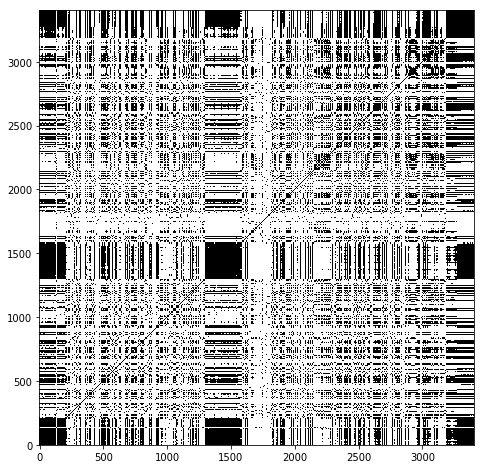

In [17]:

from pyts.image import RecurrencePlots
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)

X_rp = rp.fit_transform(df_1_avged.reshape(1,-1))
# X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show()



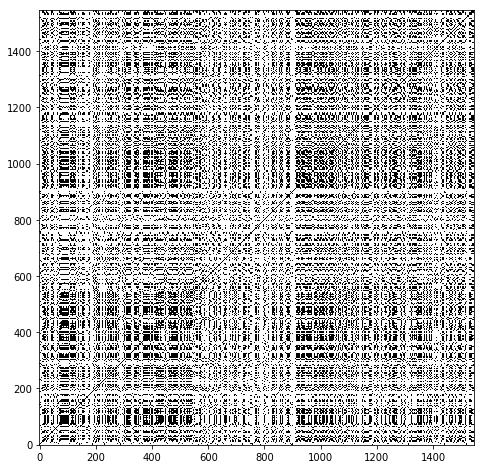

In [19]:
X_rp = rp.fit_transform(df_2["Ankle_1"].values.reshape(1,-1))
# X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show()


In [16]:
def avgData(data, limit, window):
    data = np.array([sum(data.iloc[i:i+window])/window for i in range(0,limit, window)])
    return data
from pyts.image import RecurrencePlots

# Recurrence plot transformation
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)

def sectionRPview(column_data, section, rem, label, limit = 0):
    zipped_sections = zip(range(0,section), range(1,section+1))
    for i, j in zipped_sections:
        
        data = column_data[i*limit:j*limit]
        print(i, j)
        RPview(data, label = label + str(i)+"_"+str(j))
    RPview(column_data[section*limit:], label = label +"_"+"rem")
    
    
        
    
def RPview(data, limit = 0, window = 0, avg = False, label = None):
    if avg == True:
        data = avgData(data, limit, window)
        X_rp = rp.fit_transform(data.values.reshape(1,-1))
        plt.imshow(X_rp[0], cmap='gray', origin='lower')
        
    else:
        X_rp = rp.fit_transform(data.values.reshape(1, -1))
        plt.imshow(X_rp[0], origin='lower')

In [27]:
sections_non_fog = []
rem_non_fog = []
for i in range(len(df_non_fog)):
    sections_non_fog.append(df_non_fog[i].shape[0]//4000)
    rem_non_fog.append(df_non_fog[i].shape[0]%4000)

In [28]:
zipped_non_fog = zip(sections_non_fog,rem_non_fog, range(12,len(df_non_fog)))
for b,c,d in zipped_non_fog:
    print(b,c,d)

5 2064 12
18 2848 13
14 889 14
17 2365 15
35 2722 16


In [24]:
for i in range(12,17):
    print(df_non_fog[i].shape[0], df_non_fog[i].shape[0]//4000)

87655 21
14335 3
99110 24
21121 5
19842 4


In [14]:
os.chdir("/home/aniketh/Documents/fog-parkinsons/rps/120s/non_fog")
def view_data(data_list, limit_ = 4000):
    for section_, rem_, df_index in zipped_non_fog:
        print(section_, rem_, df_index)
        for column_index in range(1,10):
            sectionRPview(data_list[df_index].iloc[:,column_index],section = section_, rem = rem_ ,label = str(df_index)+"_"+str(column_index)+"_", limit = limit_)
    

In [15]:
def avgData(data, limit, window):
    data = np.array([sum(data.iloc[i:i+window])/window for i in range(0,limit, window)])
    return data
from pyts.image import RecurrencePlots

# Recurrence plot transformation
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)

def sectionRPsave(column_data, section, rem, label, limit = 0):
    if section != 0 :
        zipped_sections = zip(range(0,section), range(1,section+1))
        for i, j in zipped_sections:
            data = column_data[i*limit:j*limit]
            RPsave(data, label = label + str(i)+"_"+str(j))
        RPsave(column_data[section*limit:], label = label +"_rem")
    else:
        RPsave(column_data, label = label +"_0_section")
    
        
    
def RPsave(data, limit = 0, window = 0, avg = False, label = None):
    if avg == True:
        data = avgData(data, limit, window)
        X_rp = rp.fit_transform(data.values.reshape(1,-1))
        plt.imsave(label, X_rp[0], cmap='gray', origin='lower')
        
    else:
        X_rp = rp.fit_transform(data.values.reshape(1, -1))
        plt.imsave(label, X_rp[0], origin='lower')

In [38]:
os.chdir("/home/aniketh/Documents/fog-parkinsons/rps/120s/non_fog")
def create_data(data_list, limit_ = 4000):
    for section_, rem_, df_index in zipped_non_fog:
        for column_index in range(1,10):
            sectionRPsave(data_list[df_index].iloc[:,column_index],section = section_, rem = rem_ ,label = str(df_index)+"_"+str(column_index)+"_", limit = limit_)
    

In [30]:
sections_non_fog = []
rem_non_fog = []
for i in df_non_fog:
    sections_non_fog.append(i.shape[0]//4000)
    rem_non_fog.append(i.shape[0]%4000)

In [37]:
# zipped_non_fog = zip(sections_non_fog,rem_non_fog, range(len(df_non_fog)))
# for b,c,d in zipped_non_fog:
#     print(b,c,d)

In [40]:
create_data(df_non_fog)

In [43]:
for i in range(17):
    print(df_fog[i].shape[0])

3537
16034
8072
3876
0
1547
17353
13017
1337
0
12859
17287
5147
2306
8413
0
0


In [16]:
indices = [0,1,2,3,5,6,7,8,10,11,12,13,14]
df_fog_1 = []
for i in indices:
    df_fog_1.append(df_fog[i])
for i in range(13):
    print(df_fog_1[i].shape[0])

3537
16034
8072
3876
1547
17353
13017
1337
12859
17287
5147
2306
8413


In [17]:
df_fog = df_fog_1

In [18]:
sections_fog = []
rem_fog = []
for i in df_fog:
    sections_fog.append(i.shape[0]//4000)
    rem_fog.append(i.shape[0]%4000)

In [19]:
zipped_fog = zip(sections_fog,rem_fog, range(len(df_fog)))
for b,c,d in zipped_fog:
    print(b,c,d)

0 3537 0
4 34 1
2 72 2
0 3876 3
0 1547 4
4 1353 5
3 1017 6
0 1337 7
3 859 8
4 1287 9
1 1147 10
0 2306 11
2 413 12


In [20]:
os.chdir("/home/aniketh/Documents/fog-parkinsons/rps/120s/fog")
zipped_fog = zip(sections_fog,rem_fog, range(len(df_fog)))
def create_data(data_list, limit_ = 4000):
    for section_, rem_, df_index in zipped_fog:
        for column_index in range(1,10):
            sectionRPsave(data_list[df_index].iloc[:,column_index],section = section_, rem = rem_ ,label = str(df_index)+"_"+str(column_index)+"_", limit = limit_)
    

In [21]:
create_data(df_fog)

KeyboardInterrupt: 

In [12]:
import cv2 
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 
from sklearn.metrics import confusion_matrix

In [1]:
fog1_path = "/home/aniketh/Documents/fog-parkinsons/rps/120s/fog"
non_fog_path = "/home/aniketh/Documents/fog-parkinsons/rps/120s/non_fog"

data = []
labels = []
IMG_SIZE = 100

def create_train_data(): 
    
    for img in tqdm(os.listdir(non_fog_path)): 

        path = os.path.join(non_fog_path, img) 

        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
        img = cv2.imread(path) 

        # resizing the image for processing them in the covnet 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        
        img = np.array(img)/255.0
        
        img = img - np.mean(img)

        # final step-forming the training data list with numpy array of the images 
        data.append(img)
        labels.append(0)

    for img in tqdm(os.listdir(fog1_path)): 

        path = os.path.join(fog1_path, img) 

        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
        img = cv2.imread(path) 

        # resizing the image for processing them in the covnet 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        
        img = np.array(img)/255.0
        
        img = img - np.mean(img)

        # final step-forming the training data list with numpy array of the images 
        data.append(img)
        labels.append(1)

   


    # shuffling of the training data to preserve the random state of our data 
    os.chdir("/home/aniketh/Documents/fog-parkinsons") 
    np.save("data_all_120s.npy", data)
    np.save("labels_all_120s.npy", labels)

In [5]:
data_np = np.array(data)
labels_np = np.array(labels)

In [6]:
len(data)

4398

In [3]:
create_train_data()

100%|██████████| 2161/2161 [06:46<00:00,  5.08it/s]


In [119]:
for i in range(len(data)):
    zipped = zip(range(0,10), range(1, 11))
    for i, j in zipped:
        data = np.array(data[i*100:j*100])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [1]:
from keras import Sequential
from keras import models
from keras import layers
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
data = np.load("data_all_120s.npy")
labels = np.load("labels_all_120s.npy")
data_np = np.array(data)
labels_np = np.array(labels)

Using TensorFlow backend.


In [2]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split( X_train, y_train, test_size=0.33, random_state=2)

## 1 layer of convolution - total data

In [4]:
IMG_SIZE = 100
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

model.fit(x=np.array(X_train), y=np.array(y_train), batch_size=50, epochs=5,
          validation_data = (np.array(X_validate), np.array(y_validate)), verbose=1, shuffle=True)

Train on 1993 samples, validate on 983 samples
Epoch 1/5
1993/1993 [==============================] - 17s 9ms/step - loss: 0.5848 - acc: 0.7030 - val_loss: 0.4741 - val_acc: 0.7477
Epoch 2/5
1993/1993 [==============================] - 17s 8ms/step - loss: 0.3537 - acc: 0.8515 - val_loss: 0.3101 - val_acc: 0.8596
Epoch 3/5
1993/1993 [==============================] - 17s 8ms/step - loss: 0.2002 - acc: 0.9282 - val_loss: 0.1680 - val_acc: 0.9349
Epoch 4/5
1993/1993 [==============================] - 17s 8ms/step - loss: 0.1065 - acc: 0.9674 - val_loss: 0.1387 - val_acc: 0.9451
Epoch 5/5
1993/1993 [==============================] - 17s 8ms/step - loss: 0.0510 - acc: 0.9875 - val_loss: 0.1633 - val_acc: 0.9410


In [3]:
sens_l = []
spec_l = []
acc_l = []
def load_model():
    
    
    
    IMG_SIZE = 100
    model = Sequential()

    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(
     optimizer = "adam",
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    return model

def train_evaluate(model, data_train, labels_train, data_test, labels_test):
    model.fit(x=data_train, y=labels_train, batch_size=5, epochs=1,
         verbose=1, shuffle=True)
    loss, acc = model.evaluate(x=data_test, y=labels_test, batch_size=5, verbose=1)
    print(loss, acc)
    y_pred = model.predict(data_test, verbose=0)
    y_pred = y_pred.round()
    y_pred = np.array([int(i) for i in y_pred])
    tn, fp, fn, tp = confusion_matrix(labels_test,y_pred).ravel()
    sens = tp/(tp+fn)
    sens_l.append(sens)
    spec = tn/(tn+fp)
    spec_l.append(spec)
    acc_l.append(acc)
    print(confusion_matrix(labels_test,y_pred))
    print("sens and spec is:")
    print(sens, spec)
    

from sklearn.model_selection import StratifiedKFold

if __name__ == "__main__":
    load_model()
    kFold = StratifiedKFold(n_splits=10, shuffle = True)
    for train, test in kFold.split(data_np,labels_np):
        model = None
        model = load_model()
        train_evaluate(model, data_np[train], labels_np[train], data_np[test], labels_np[test])
    print("sensitivity, specificity and accuracy:")
    print(np.mean(sens_l))
    print(np.mean(spec_l))
    print(np.mean(acc_l))
    

Epoch 1/1
445/445 [==============================] - 2s 5ms/step
0.17767835055589754 0.9438202280676766
[[211  13]
 [ 12 209]]
sens and spec is:
0.9457013574660633 0.9419642857142857
Epoch 1/1
445/445 [==============================] - 2s 5ms/step
0.22066571449159822 0.9056179828188392
[[219   5]
 [ 37 184]]
sens and spec is:
0.832579185520362 0.9776785714285714
Epoch 1/1
445/445 [==============================] - 2s 5ms/step
0.15106318514856898 0.9303370824690615
[[193  31]
 [  0 221]]
sens and spec is:
1.0 0.8616071428571429
Epoch 1/1
445/445 [==============================] - 2s 5ms/step
0.13890610609495924 0.9573033733314342
[[219   5]
 [ 14 207]]
sens and spec is:
0.9366515837104072 0.9776785714285714
Epoch 1/1
445/445 [==============================] - 2s 5ms/step
0.11424970403941495 0.9617977550860202
[[212  12]
 [  5 216]]
sens and spec is:
0.9773755656108597 0.9464285714285714
Epoch 1/1
444/444 [==============================] - 2s 5ms/step
0.12174904875801813 0.95945946187586

TypeError: mean() missing 1 required positional argument: 'a'

In [9]:
print("sensitivity, specificity and accuracy:")
print(np.mean(sens_l))
print(np.mean(spec_l))
print(np.mean(acc_l))

sensitivity, specificity and accuracy:
0.9524125874125874
0.9459300928891736
0.9491394686026107


## 2 layers CV

In [10]:
sens_l = []
spec_l = []
acc_l = []
def load_model():
    
    
    
    IMG_SIZE = 100
    model = Sequential()

    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(
     optimizer = "adam",
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    return model

def train_evaluate(model, data_train, labels_train, data_test, labels_test):
    model.fit(x=data_train, y=labels_train, batch_size=5, epochs=1,
         verbose=1, shuffle=True)
    loss, acc = model.evaluate(x=data_test, y=labels_test, batch_size=5, verbose=1)
    print(loss, acc)
    y_pred = model.predict(data_test, verbose=0)
    y_pred = y_pred.round()
    y_pred = np.array([int(i) for i in y_pred])
    tn, fp, fn, tp = confusion_matrix(labels_test,y_pred).ravel()
    sens = tp/(tp+fn)
    sens_l.append(sens)
    spec = tn/(tn+fp)
    spec_l.append(spec)
    acc_l.append(acc)
    print(confusion_matrix(labels_test,y_pred))
    print("sens and spec is:")
    print(sens, spec)
    

from sklearn.model_selection import StratifiedKFold

if __name__ == "__main__":
    load_model()
    kFold = StratifiedKFold(n_splits=10, shuffle = True)
    for train, test in kFold.split(data_np,labels_np):
        model = None
        model = load_model()
        train_evaluate(model, data_np[train], labels_np[train], data_np[test], labels_np[test])
    print("sensitivity, specificity and accuracy:")
    print(np.mean(sens_l))
    print(np.mean(spec_l))
    print(np.mean(acc_l))
    

Epoch 1/1
445/445 [==============================] - 3s 7ms/step
0.38503636979613076 0.8112359649679634
[[170  54]
 [ 30 191]]
sens and spec is:
0.8642533936651584 0.7589285714285714
Epoch 1/1
445/445 [==============================] - 3s 7ms/step
0.4535754065165359 0.7483146127020375
[[218   6]
 [106 115]]
sens and spec is:
0.5203619909502263 0.9732142857142857
Epoch 1/1
445/445 [==============================] - 3s 7ms/step
0.4171969120422106 0.8292134903120191
[[154  70]
 [  6 215]]
sens and spec is:
0.9728506787330317 0.6875
Epoch 1/1
445/445 [==============================] - 3s 7ms/step
0.36323964243409423 0.8696629287821523
[[190  34]
 [ 24 197]]
sens and spec is:
0.8914027149321267 0.8482142857142857
Epoch 1/1
445/445 [==============================] - 3s 7ms/step
0.3670112067490837 0.8786516916216089
[[191  33]
 [ 21 200]]
sens and spec is:
0.9049773755656109 0.8526785714285714
Epoch 1/1
444/444 [==============================] - 3s 8ms/step
0.4006461069692631 0.84234234905457

In [11]:
sens_l = []
spec_l = []
acc_l = []
def load_model():
    
    
    
    IMG_SIZE = 100
    model = Sequential()

    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(
     optimizer = "adam",
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    return model

def train_evaluate(model, data_train, labels_train, data_test, labels_test):
    model.fit(x=data_train, y=labels_train, batch_size=5, epochs=1,
         verbose=1, shuffle=True)
    loss, acc = model.evaluate(x=data_test, y=labels_test, batch_size=5, verbose=1)
    print(loss, acc)
    y_pred = model.predict(data_test, verbose=0)
    y_pred = y_pred.round()
    y_pred = np.array([int(i) for i in y_pred])
    tn, fp, fn, tp = confusion_matrix(labels_test,y_pred).ravel()
    sens = tp/(tp+fn)
    sens_l.append(sens)
    spec = tn/(tn+fp)
    spec_l.append(spec)
    acc_l.append(acc)
    print(confusion_matrix(labels_test,y_pred))
    print("sens and spec is:")
    print(sens, spec)
    

from sklearn.model_selection import StratifiedKFold

if __name__ == "__main__":
    load_model()
    kFold = StratifiedKFold(n_splits=10, shuffle = True)
    for train, test in kFold.split(data_np,labels_np):
        model = None
        model = load_model()
        train_evaluate(model, data_np[train], labels_np[train], data_np[test], labels_np[test])
    print("sensitivity, specificity and accuracy:")
    print(np.mean(sens_l))
    print(np.mean(spec_l))
    print(np.mean(acc_l))
    

Epoch 1/1
445/445 [==============================] - 4s 8ms/step
0.587406590748369 0.5955056204889597
[[221   3]
 [177  44]]
sens and spec is:
0.19909502262443438 0.9866071428571429
Epoch 1/1
445/445 [==============================] - 4s 9ms/step
0.5777921402052547 0.7213483203328057
[[100 124]
 [  0 221]]
sens and spec is:
1.0 0.44642857142857145
Epoch 1/1
445/445 [==============================] - 4s 9ms/step
0.505225981080779 0.732584278067846
[[206  18]
 [101 120]]
sens and spec is:
0.5429864253393665 0.9196428571428571
Epoch 1/1
445/445 [==============================] - 4s 9ms/step
0.4659195863798763 0.784269673101018
[[159  65]
 [ 31 190]]
sens and spec is:
0.8597285067873304 0.7098214285714286
Epoch 1/1
445/445 [==============================] - 4s 9ms/step
0.5564166146717714 0.6943820346607251
[[142  82]
 [ 54 167]]
sens and spec is:
0.755656108597285 0.6339285714285714
Epoch 1/1
444/444 [==============================] - 4s 9ms/step
0.4644838091204161 0.813063072896487
[[178 

In [12]:
sens_l = []
spec_l = []
acc_l = []
def load_model():
    
    
    
    IMG_SIZE = 100
    model = Sequential()

    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(
     optimizer = "adam",
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    return model

def train_evaluate(model, data_train, labels_train, data_test, labels_test):
    model.fit(x=data_train, y=labels_train, batch_size=5, epochs=1,
         verbose=1, shuffle=True)
    loss, acc = model.evaluate(x=data_test, y=labels_test, batch_size=5, verbose=1)
    print(loss, acc)
    y_pred = model.predict(data_test, verbose=0)
    y_pred = y_pred.round()
    y_pred = np.array([int(i) for i in y_pred])
    tn, fp, fn, tp = confusion_matrix(labels_test,y_pred).ravel()
    sens = tp/(tp+fn)
    sens_l.append(sens)
    spec = tn/(tn+fp)
    spec_l.append(spec)
    acc_l.append(acc)
    print(confusion_matrix(labels_test,y_pred))
    print("sens and spec is:")
    print(sens, spec)
    

from sklearn.model_selection import StratifiedKFold

if __name__ == "__main__":
    load_model()
    kFold = StratifiedKFold(n_splits=10, shuffle = True)
    for train, test in kFold.split(data_np,labels_np):
        model = None
        model = load_model()
        train_evaluate(model, data_np[train], labels_np[train], data_np[test], labels_np[test])
    print("sensitivity, specificity and accuracy:")
    print(np.mean(sens_l))
    print(np.mean(spec_l))
    print(np.mean(acc_l))
    

Epoch 1/1
445/445 [==============================] - 5s 10ms/step
0.47692535752744486 0.773033718212267
[[153  71]
 [ 30 191]]
sens and spec is:
0.8642533936651584 0.6830357142857143
Epoch 1/1
445/445 [==============================] - 5s 11ms/step
0.49131092709604274 0.7258427102914017
[[173  51]
 [ 71 150]]
sens and spec is:
0.6787330316742082 0.7723214285714286
Epoch 1/1
445/445 [==============================] - 5s 11ms/step
0.9301423961908185 0.5123595509971126
[[223   1]
 [216   5]]
sens and spec is:
0.02262443438914027 0.9955357142857143
Epoch 1/1
445/445 [==============================] - 5s 12ms/step
0.5282952224605539 0.7595505704370777
[[130  94]
 [ 13 208]]
sens and spec is:
0.9411764705882353 0.5803571428571429
Epoch 1/1
445/445 [==============================] - 5s 12ms/step
0.5855049963077802 0.7011236002605953
[[ 93 131]
 [  2 219]]
sens and spec is:
0.9909502262443439 0.41517857142857145
Epoch 1/1
444/444 [==============================] - 5s 12ms/step
0.77869468626040

In [5]:
model.evaluate(x=np.array(X_test), y=np.array(y_test), batch_size=30, verbose=1)

1466/1466 [==============================] - 5s 4ms/step


[0.11489658249671715, 0.955661650569182]

## Total dataset for 2 layers of convolution

In [7]:
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Dropout(0.25))
model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

model.fit(x=np.array(X_train), y=np.array(y_train), batch_size=50, epochs=5,
          validation_data = (np.array(X_validate), np.array(y_validate)), verbose=1, shuffle=True)

Train on 1993 samples, validate on 983 samples
Epoch 1/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.6401 - acc: 0.6272 - val_loss: 0.5547 - val_acc: 0.7213
Epoch 2/5
1993/1993 [==============================] - 21s 11ms/step - loss: 0.5125 - acc: 0.7476 - val_loss: 0.4834 - val_acc: 0.7670
Epoch 3/5
1993/1993 [==============================] - 21s 11ms/step - loss: 0.4373 - acc: 0.7762 - val_loss: 0.4075 - val_acc: 0.8026
Epoch 4/5
1993/1993 [==============================] - 21s 11ms/step - loss: 0.3593 - acc: 0.8329 - val_loss: 0.3600 - val_acc: 0.8454
Epoch 5/5
1993/1993 [==============================] - 21s 11ms/step - loss: 0.3176 - acc: 0.8580 - val_loss: 0.3084 - val_acc: 0.8606


In [8]:
model.evaluate(x=np.array(X_test), y=np.array(y_test), batch_size=30, verbose=1)

1466/1466 [==============================] - 7s 5ms/step


[0.2918369301466467, 0.8806275511503545]

## 3 layers

In [12]:
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

model.fit(x=np.array(X_train), y=np.array(y_train), batch_size=30, epochs=5,
          validation_data = (np.array(X_validate), np.array(y_validate)), verbose=1, shuffle=True)

Train on 1993 samples, validate on 983 samples
Epoch 1/5
1993/1993 [==============================] - 23s 11ms/step - loss: 0.6562 - acc: 0.5926 - val_loss: 0.6075 - val_acc: 0.6989
Epoch 2/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.5416 - acc: 0.7296 - val_loss: 0.4894 - val_acc: 0.7406
Epoch 3/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.4779 - acc: 0.7782 - val_loss: 0.4881 - val_acc: 0.7569
Epoch 4/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.4177 - acc: 0.8063 - val_loss: 0.3846 - val_acc: 0.8271
Epoch 5/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.3779 - acc: 0.8284 - val_loss: 0.3652 - val_acc: 0.8525


In [13]:
model.evaluate(x=np.array(X_test), y=np.array(y_test), batch_size=30, verbose=1)

1466/1466 [==============================] - 7s 5ms/step


[0.33772831592114205, 0.8738062642768818]

In [139]:
y_preds = model.predict(np.array(X_test), batch_size=None, verbose=0)

In [144]:
y_preds[0][0]

0.0013323209

In [146]:
y_pred = []

for i in range(len(y_preds)):
    if y_preds[i][0] >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [147]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[2952,  456],
       [ 108, 3221]])

In [148]:
model.save("model_60s_3conv.h5")

## 4 layers deep

In [22]:
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

model.fit(x=np.array(X_train), y=np.array(y_train), batch_size=30, epochs=5,
          validation_data = (np.array(X_validate), np.array(y_validate)), verbose=1, shuffle=True)

Train on 1488 samples, validate on 733 samples
Epoch 1/5
1488/1488 [==============================] - 19s 13ms/step - loss: 0.6756 - acc: 0.5773 - val_loss: 0.6210 - val_acc: 0.7271
Epoch 2/5
1488/1488 [==============================] - 18s 12ms/step - loss: 0.5541 - acc: 0.7191 - val_loss: 0.4999 - val_acc: 0.7626
Epoch 3/5
1488/1488 [==============================] - 18s 12ms/step - loss: 0.4841 - acc: 0.7668 - val_loss: 0.4897 - val_acc: 0.7640
Epoch 4/5
1488/1488 [==============================] - 18s 12ms/step - loss: 0.4778 - acc: 0.7675 - val_loss: 0.5171 - val_acc: 0.7271
Epoch 5/5
1488/1488 [==============================] - 18s 12ms/step - loss: 0.4567 - acc: 0.7849 - val_loss: 0.4618 - val_acc: 0.8035


In [24]:
model.evaluate(x=np.array(X_test), y=np.array(y_test), batch_size=30, verbose=1)

2221/2221 [==============================] - 12s 5ms/step


[0.4625023849264881, 0.80684375988369]

## 5 Layers


In [16]:
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 5, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

model.fit(x=np.array(X_train), y=np.array(y_train), batch_size=30, epochs=5,
          validation_data = (np.array(X_validate), np.array(y_validate)), verbose=1, shuffle=True)

Train on 1993 samples, validate on 983 samples
Epoch 1/5
1993/1993 [==============================] - 23s 12ms/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6919 - val_acc: 0.5982
Epoch 2/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.6859 - acc: 0.5670 - val_loss: 0.6721 - val_acc: 0.7223
Epoch 3/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.6240 - acc: 0.6834 - val_loss: 0.6329 - val_acc: 0.6348
Epoch 4/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.5225 - acc: 0.7546 - val_loss: 0.5242 - val_acc: 0.7508
Epoch 5/5
1993/1993 [==============================] - 22s 11ms/step - loss: 0.4818 - acc: 0.7727 - val_loss: 0.5318 - val_acc: 0.7599


In [17]:
model.evaluate(x=np.array(X_test), y=np.array(y_test), batch_size=30, verbose=1)

1466/1466 [==============================] - 7s 5ms/step


[0.5488781237423339, 0.7544338336420254]